In [1]:
!pip install pyro-ppl

In [21]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.set_rng_seed(101)

## 1. A simple example

Suppose an insurance company is trying to predict the cost in dollars of COVID-19 treatment of a patient. They are able to come up with a rough guess of the cost based on the treatment prescribed utilizing information from prior expenses of other patients. However healthcare varies across provinces and cities so the actual cost for the same treatment is always a slight variation around this guess.

Furthermore, the total expenditure also varies slightly across patients with the same treatment because of things like ambulance costs, demand etc.

The model is summarized as:

**cost | guess ∼ Normal(guess,1)** 

**expenditure | guess,cost ∼ Normal(cost,0.75)**  

Disclaimer: The author (clearly) has zero idea how healthcare works and this example is purely hypothetical!

In [3]:
# The model is given by the following stochastic function

def scale(guess):
    cost = pyro.sample("cost", dist.Normal(guess, 1.0))
    return pyro.sample("expenditure", dist.Normal(cost, 0.75))

### 1.1 Conditioning using pyro.condition()

Condition generative models on observed data & infer latent factors that produced the data

**IMPORTANT:** Pyro separates the expression of conditioning from its evaluation via inference, making it possible to write a model once and condition it on many different observations. This abstraction is another key difference between traditional bayesian inference and probabilistic programming.

```pyro.condition()``` allows to constrain values of sample statements.

Input: model, dictionary of observations  
Output: new model with same i/p and o/p signatures but using given values in the observe statement

Say we want to infer:

**cost | guess, expenditure = 11k ~ ?**

In [4]:
conditioned_scale = pyro.condition(scale, data={"expenditure": 11}) # conditions scale based on observed expenditure of $11k

We can defer the condition i.e. pass it as a function parameter (thus adding to the flexibility of our probabilistic program):

In [5]:
def deferred_conditioned_scale(expenditure, guess):
    return pyro.condition(scale, data={"expenditure": expenditure})(guess)

Finally, instead of using ```pyro.condition()``` separately it may sometimes be more convenient to use the ```obs``` argument in ```pyro.sample()```

In [6]:
def scale_obs(guess):  # equivalent to conditioned_scale above
    cost = pyro.sample("cost", dist.Normal(guess, 1.0))
     # here we condition on measurement == 11
    return pyro.sample("expenditure", dist.Normal(cost, 0.75), obs=11)

### 1.2 Guide Functions and pyro.param()

We know that computing the exact posterior in Bayesian Inference can be a very hard or in worst case an intractable problem. The power of probabilistic inference derives from approximating the posterior. 

Guide function = Arbitrary stochastic functions -> serve as approximate posterior

**CONDITIONS FOR GUIDE**

- All unobserved (i.e. not conditioned) sample statements that appear in the model appear in the guide
- The guide has the same input structure as the model

Guide functions are:

- **Proposal distribution** for sampling-based inference mechanisms i.e. importance sampling, rejection sampling, Sequential Monte Carlo, MCMC etc
- **Variational distribution** for variational inference mechanisms i.e. SVI, Amortized VI etc 

The conditions hold for both types of guides in Pyro to streamline the inference process and reduce the dependence on the inference mechanism used.

We parameterize the guide function using ```pyro.param()```. Technically there can be guide functions where we can analytically solve and fix the posterior but they are usually for special and simpler models (e.g. conjugate priors)

In [7]:
def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("cost", dist.Normal(a, torch.abs(b))) 

# Note that the guide does not have the same returned values as the original model. 
# We just sample for the variables that we will infer in the guide

Additionaly ```constrainsts``` can be used to set constraints on the values a parameter can take. For example we can replace torch.abs() we used above with a constraint that the standard deviation of a normal distribution is always positive

In [8]:
from torch.distributions import constraints

def scale_parametrized_guide_constrained(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("cost", dist.Normal(a, b))

### 1.3 Inference

Exact mechanisms are discussed later. We pass the model, guide, a Pytorch optimizer and loss function to the SVI engine of Pyro and obtain our parameters a and b for now

In [12]:
guess = 9. # suppose the insurance firm guessed a cost of $9k and the actual expenditure was $11k (from before)

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide_constrained,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses, a,b  = [], [], []
num_steps = 2500

for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

a =  10.330216407775879
b =  0.6035094857215881


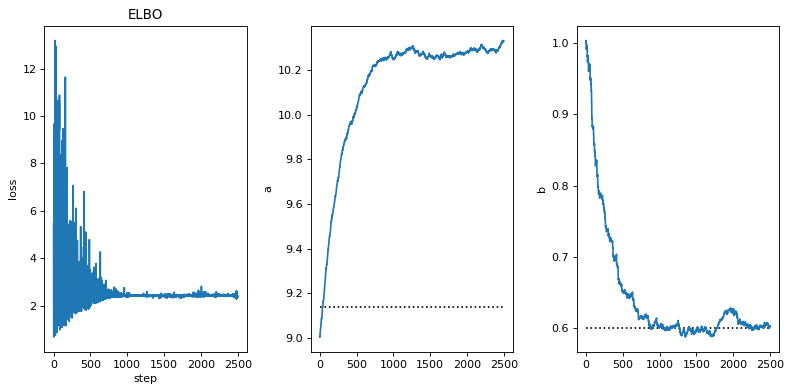

In [20]:
fig=plt.figure(figsize=(10, 5), dpi= 80)

plt.subplot(1,3,1)
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())
plt.tight_layout()

plt.subplot(1,3,2)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')
plt.tight_layout()

plt.subplot(1,3,3)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

It can be shown that analytically obtained a and b are:

a = (0.75^2 * guess + 11)/ (1 + 0.75^2) = 10.28  
b = sqrt(0.75^2/(1 + 0.75^2)) = 0.6

SVI obtains parameters which are are very close (model, guide are from same family here so it works better)

## 2. A (slightly) larger example: Bayesian Regression

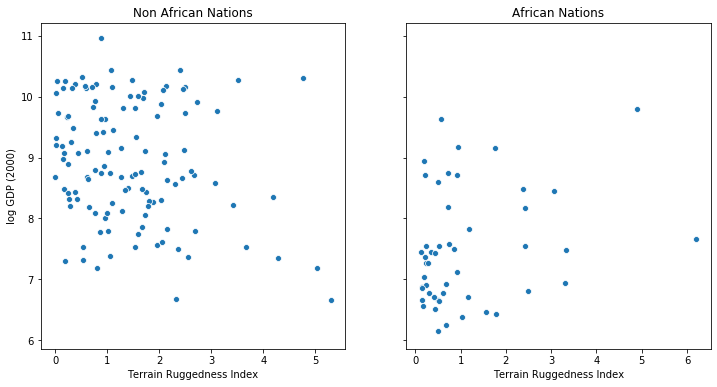

In [22]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"],
            non_african_nations["rgdppc_2000"],
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"],
                african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [ ]:
# TODO